Study of the T-seed selection using BDT- XGBoost classifier
-----------------------------
This script contains all of my study based on **BDT - [XGBoost](https://github.com/dmlc/xgboost)**.  
I want to compare results of sklearn's GradientBoostedClassifier and XGBoost.  
[Rumour](https://github.com/dmlc/xgboost/blob/master/demo/README.md) has it that XGBoost is better than sklern's Gradient Boosted Classifier. We will see.  
The study contains similar steps as Baseline-BDT. 

Study roadmap 
--------------
1. Train  the first version of XGBoost with default parameters and without any features engineering. Just to know baseline score. 
2. Add basic features transformation eg. pseudorapidity and absolute values. 
3. Tune hiperparameters. As a first take care of number of trees and learning rate
4. Try to balance training dataset. 
4. Add linear combination and features's ratios  
   4.1 See at the learning curve. If needed perform step 3 for the new dataset.  
5. Speedup the algorithm using idea of [bonsai Decision Trees](http://arxiv.org/pdf/1210.6861v1.pdf)  
   I will use implementation of bBDT from [hep_ml](https://github.com/arogozhnikov/hep_ml/blob/master/hep_ml/speedup.py). See detailed study description below. 
6. Implement bBDT in C++  

The result to beat is 0.8131906
-----------


In [22]:
print ("kernel is alive!")

kernel is alive!


In [2]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search
from sklearn.metrics import classification_report

from sklearn.externals import joblib

import xgboost as xgb

from hep_ml.speedup import LookupClassifier

Welcome to ROOTaaS 6.06/02


As a very first step I need to grab training data form the NTpule. 
--------------------------
To obtain this goal I will use **root_numpy**, that allows me to convert root NTuple to pandas.Dataframe

In [3]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)
data.head()

,is_true_seed,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,False,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572
1,False,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081
2,False,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975
3,False,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753
4,True,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980


Train xgboost classifier with default parameters
-------------
At first I need to split data into training and test subsets. 

In [5]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.5 )

In [ ]:
gb = xgb.XGBClassifier(max_depth=6, learning_rate=0.1,n_estimators = 100)
gb.fit(trainX,trainY)

In [9]:
print "ROC AUC score"
roc_auc_score(testY, gb.predict_proba(testX)[:, 1])

ROC AUC score


0.79019802348145729

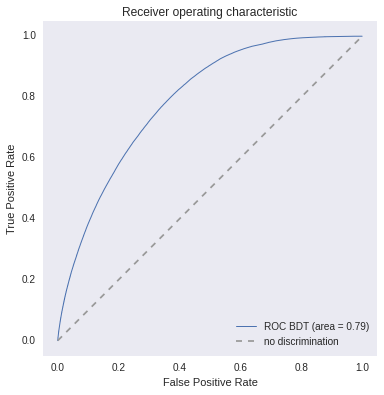

In [10]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Feature Engineering
======================
Add transformated features
-------------------
At the begining let's try some very basic feature transformation.  
I also add pseudorapidity and seed_r

In [6]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=numpy.abs(data['seed_x'])
    out["abs_seed_y"]=numpy.abs(data['seed_y'])
    out["abs_seed_tx"]=numpy.abs(data['seed_tx'])
    out["abs_seed_ty"]=numpy.abs(data['seed_ty'])
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))    
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    return out

In [7]:
new_data = basic_transforamtion(data)
new_features = new_data.drop("is_true_seed", axis=1).astype(numpy.float64)
new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572,1263.157617,517.249191,0.524220,0.061572,1364.959300,0.505958
1,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081,1264.522435,99.363473,0.480288,0.009081,1268.420312,0.463589
2,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975,1521.093160,196.064807,0.382802,0.025975,1533.677219,0.374842
3,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753,1563.145597,483.850246,0.369674,0.058753,1636.317578,0.366082
4,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980,1641.727752,411.084316,0.646627,0.054980,1692.412576,0.610352


In [15]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )

In [19]:
gb2 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, subsample=0.8, max_depth=6)
gb2.fit(new_trainX,new_trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [20]:
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

0.80090517263682215

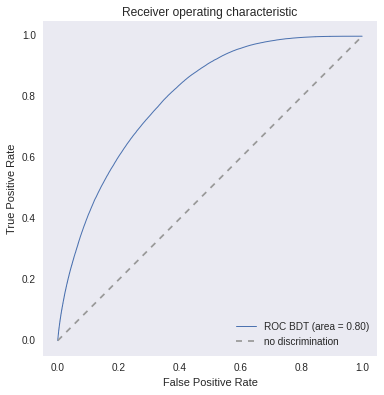

In [21]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Hyperparameters optimalization
----------------
Let's try to improve above classifier by serching for the best hyperparameters values. 
In the first iteration I want to find the best values of following hyperparameters:
* Number of trees. The cosidered range of n_estimators is between 50 and 250, step = 50
* learning rate in range 0.01-3 with semilogaritmic step

I use only 10% of data for grid search. Should be enough.

In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {"n_estimators": [x  for x in range(49,251) if x % 50 == 0],
                   "learning_rate": [0.01, 0.03,0.1,0.3,1]}
print(gb_grid_params)

gb_gs = xgb.XGBClassifier()

clf = grid_search.GridSearchCV(gb_gs,                               
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=8);
clf.fit(train_gs_X, train_gs_Y);


In [8]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'n_estimators': 250, 'learning_rate': 0.3}
Grid scores on development set:
0.740 (+/-0.002) for {'n_estimators': 50, 'learning_rate': 0.01}
0.743 (+/-0.003) for {'n_estimators': 100, 'learning_rate': 0.01}
0.746 (+/-0.002) for {'n_estimators': 150, 'learning_rate': 0.01}
0.750 (+/-0.003) for {'n_estimators': 200, 'learning_rate': 0.01}
0.753 (+/-0.004) for {'n_estimators': 250, 'learning_rate': 0.01}
0.746 (+/-0.002) for {'n_estimators': 50, 'learning_rate': 0.03}
0.757 (+/-0.004) for {'n_estimators': 100, 'learning_rate': 0.03}
0.767 (+/-0.005) for {'n_estimators': 150, 'learning_rate': 0.03}
0.773 (+/-0.004) for {'n_estimators': 200, 'learning_rate': 0.03}
0.775 (+/-0.004) for {'n_estimators': 250, 'learning_rate': 0.03}
0.770 (+/-0.004) for {'n_estimators': 50, 'learning_rate': 0.1}
0.779 (+/-0.004) for {'n_estimators': 100, 'learning_rate': 0.1}
0.782 (+/-0.005) for {'n_estimators': 150, 'learning_rate': 0.1}
0.784 (+/-0.005) for {'n_e

In [9]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )
gb2 = xgb.XGBClassifier(learning_rate=0.3, n_estimators=250, max_depth=6)
gb2.fit(new_trainX,new_trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [10]:
print "ROC AUC score - model XGBoost with learning rate 0.3 and number of trees 250"
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

ROC AUC score - model XGBoost with learning rate 0.3 and number of trees 250


0.81758089824153213

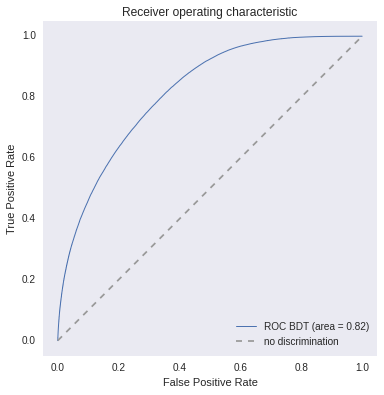

In [11]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Show dependency of BDT quality on the number of trees. 
----------
I plot the learning curve, number of trees vs score, of the BDT classifier.  
This plot allows me to decide weather or not decrease the number of trees. 

To obtain this values I use staged_predict_proba

In [ ]:
tree_scores = [] 
for tree_nb in range(1,249):
    proba = gb2.predict_proba(new_testX,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(new_testY, predicted)
    tree_scores.append(score)

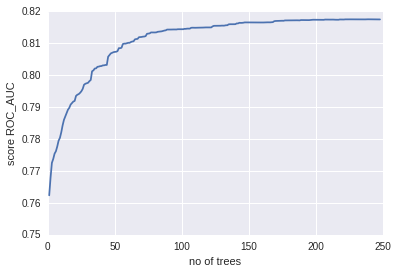

In [17]:
x = numpy.array([x  for x in range(1,249)])
plt.figure()
plt.plot(x,tree_scores)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Save model to file 
-------
It is a good idea to save BDT parameters to file for further study.  
I use **sklearn.externals.joblib**. According to the documentation is more effitient than pickle. 

In [19]:
joblib.dump(gb2, 'models/XGBoost_200tree.pkl') 

['models/XGBoost_200tree.pkl',
 'models/XGBoost_200tree.pkl_01.npy',
 'models/XGBoost_200tree.pkl_02.npy']

Extend grid search  range of n_estimators to 600. 
-----------------
This time I want to increase hyperparameter search space. 

In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {"n_estimators": [x  for x in range(299,601) if x % 50 == 0],
                   "learning_rate": [0.1,0.3,0.7,1]}
print(gb_grid_params)

gb_gs = xgb.XGBClassifier()

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=8);
clf.fit(train_gs_X, train_gs_Y);

In [8]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'n_estimators': 450, 'learning_rate': 0.3}
Grid scores on development set:
0.787 (+/-0.005) for {'n_estimators': 300, 'learning_rate': 0.1}
0.788 (+/-0.005) for {'n_estimators': 350, 'learning_rate': 0.1}
0.789 (+/-0.006) for {'n_estimators': 400, 'learning_rate': 0.1}
0.790 (+/-0.006) for {'n_estimators': 450, 'learning_rate': 0.1}
0.791 (+/-0.006) for {'n_estimators': 500, 'learning_rate': 0.1}
0.791 (+/-0.006) for {'n_estimators': 550, 'learning_rate': 0.1}
0.792 (+/-0.007) for {'n_estimators': 600, 'learning_rate': 0.1}
0.793 (+/-0.007) for {'n_estimators': 300, 'learning_rate': 0.3}
0.794 (+/-0.008) for {'n_estimators': 350, 'learning_rate': 0.3}
0.795 (+/-0.007) for {'n_estimators': 400, 'learning_rate': 0.3}
0.795 (+/-0.006) for {'n_estimators': 450, 'learning_rate': 0.3}
0.795 (+/-0.005) for {'n_estimators': 500, 'learning_rate': 0.3}
0.794 (+/-0.005) for {'n_estimators': 550, 'learning_rate': 0.3}
0.794 (+/-0.006) for {'n_estimato

Train the new model
----------
* n_estimators 400
* learning rate 0.3

In [13]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )

gb3 = xgb.XGBClassifier( n_estimators=400, learning_rate=0.2, max_depth=6)
gb4.fit(train_X,train_y2)
joblib.dump(gb4, 'models/XGBoost_400_balanced.pkl') 

['models/XGBoost_400trees.pkl',
 'models/XGBoost_400trees.pkl_01.npy',
 'models/XGBoost_400trees.pkl_02.npy']

In [7]:
gb3 = joblib.load('models/XGBoost_400trees.pkl')
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )              

In [14]:
print "ROC AUC score"
roc_auc_score(test_Y, gb3.predict_proba(test_X)[:, 1])

ROC AUC score


0.81908188341647703

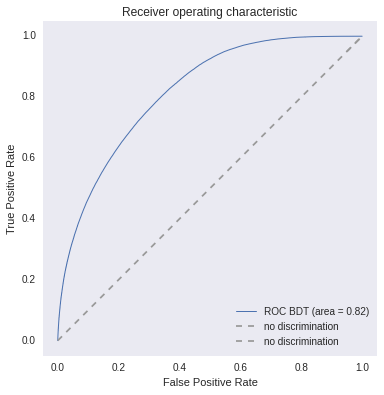

In [15]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb3.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

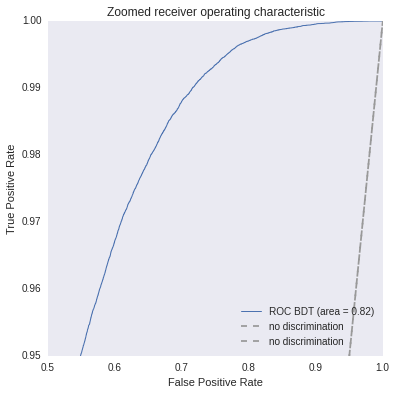

In [31]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb3.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([0.5, 1])
plt.ylim([0.95, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
tree_scores = [] 
for tree_nb in range(1,399):
    proba = gb3.predict_proba(test_X,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(test_Y, predicted)
    print("".join(["tree ",str(tree_nb), " score ", str(score)]))
    tree_scores.append(score)

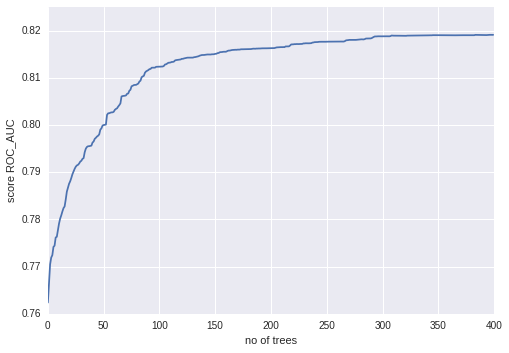

In [26]:
x = numpy.array([x  for x in range(400)])
plt.figure()
plt.plot(x,tree_scores[:400])
plt.ylim(0.76, 0.825)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Model comparison 
---------
In comparable to sklearn's model I obtained about 1% of improvement! This is quite nice. 

Balance dataset
--------------
Do to big data class misbalance I would like to balance it.  
First I split data into trainig and test sets and for training I grab only part of the ghost tracks. 

Balance via xgboost paramerer
-----------
I found parameter to be set. 
<font color="red"> I know I am dumb!!!!! </font>


In [8]:
good_track_no = counts = new_features[target == 1].count()[0]
ghost_track_no = counts = new_features[target == 0].count()[0]
print("good tracks %d") % good_track_no
print("ghost track %d") % ghost_track_no
ratio_ghost_to_good = float(ghost_track_no)/good_track_no
ratio_ghost_to_good = numpy.round(ratio_ghost_to_good, 3)
print ("ratio ghost to good %f") % ratio_ghost_to_good

good tracks 178831
ghost track 2641394
ratio ghost to good 14.770000


In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )              
gb6 = xgb.XGBClassifier( n_estimators=400, learning_rate=0.2, scale_pos_weight=ratio_ghost_to_good, max_depth=6)
gb6.fit(train_X,train_Y)
joblib.dump(gb6, 'models/XGBoost_400_balanced2.pkl') 

['models/XGBoost_400_balanced2.pkl',
 'models/XGBoost_400_balanced2.pkl_01.npy',
 'models/XGBoost_400_balanced2.pkl_02.npy']

In [8]:
print "ROC AUC score of XGBoost with 400 trees and trained using scale positive weight"
roc_auc_score(test_Y, gb6.predict_proba(test_X)[:, 1])

ROC AUC score of XGBoost with 400 trees and trained using scale positive weight


0.8168021694229628

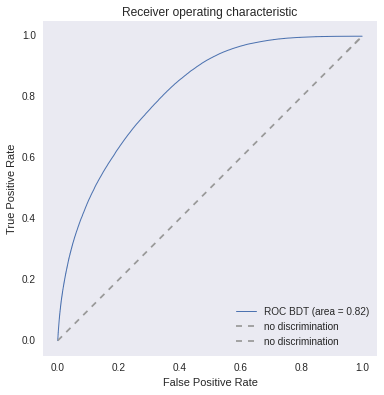

In [10]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb6.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

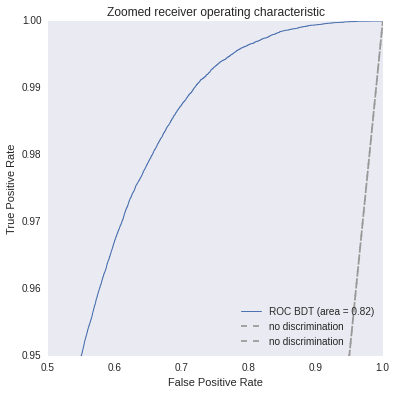

In [11]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb6.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([0.5, 1])
plt.ylim([0.95, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
tree_scores = [] 
for tree_nb in range(1,399):
    proba = gb6.predict_proba(test_X,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(test_Y, predicted)
    print("".join(["tree ",str(tree_nb), " score ", str(score)]))
    tree_scores.append(score)

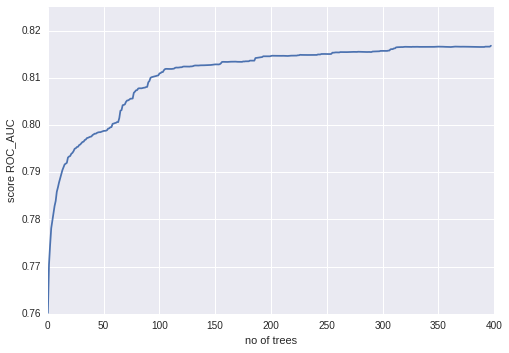

In [13]:
plt.figure()
plt.plot(tree_scores)
plt.ylim(0.76, 0.825)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Learning curve seems to decrease. I will try to find the best possible parameters. 

Perform grid search for balanced data
---------
I use grid search to look at the following hyperparameters: 
* number of trees 
  * from the previous study we know that number of trees should be higher than 300. See graph above. 
* learning rates 
    * I check range [0.05-2]  
       * I checked range [0.1-0.7]   the best scores obtained for 0.1, that why I check different region 
       
In the next step I will focus on **min_child_weight** and **max_depth** and **gamma**

In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {"n_estimators": [x  for x in range(299,501) if x % 50 == 0],
                   "learning_rate": [0.05,0.07,1,1.5,2]}
print(gb_grid_params)

gb_gs = xgb.XGBClassifier(scale_pos_weight=ratio_ghost_to_good, max_depth=6)

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=10);
clf.fit(train_gs_X, train_gs_Y);

In [9]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'n_estimators': 500, 'learning_rate': 0.07}
Grid scores on development set:
0.794 (+/-0.005) for {'n_estimators': 300, 'learning_rate': 0.05}
0.794 (+/-0.005) for {'n_estimators': 350, 'learning_rate': 0.05}
0.795 (+/-0.006) for {'n_estimators': 400, 'learning_rate': 0.05}
0.795 (+/-0.006) for {'n_estimators': 450, 'learning_rate': 0.05}
0.796 (+/-0.006) for {'n_estimators': 500, 'learning_rate': 0.05}
0.795 (+/-0.005) for {'n_estimators': 300, 'learning_rate': 0.07}
0.796 (+/-0.005) for {'n_estimators': 350, 'learning_rate': 0.07}
0.796 (+/-0.006) for {'n_estimators': 400, 'learning_rate': 0.07}
0.796 (+/-0.006) for {'n_estimators': 450, 'learning_rate': 0.07}
0.796 (+/-0.007) for {'n_estimators': 500, 'learning_rate': 0.07}
0.738 (+/-0.000) for {'n_estimators': 300, 'learning_rate': 1}
0.737 (+/-0.003) for {'n_estimators': 350, 'learning_rate': 1}
0.736 (+/-0.004) for {'n_estimators': 400, 'learning_rate': 1}
0.736 (+/-0.003) for {'n_est

Train model with obtained parameters
--------------
I use 500 trees and learning rate 0.07

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )              
gb6 = xgb.XGBClassifier( n_estimators=500, learning_rate=0.07, scale_pos_weight=ratio_ghost_to_good, max_depth=6)
gb6.fit(train_X,train_Y) 
joblib.dump(gb6, 'models/XGBoost_500_balanced_afterGS.pkl') 

['models/XGBoost_500_balanced_afterGS.pkl',
 'models/XGBoost_500_balanced_afterGS.pkl_01.npy',
 'models/XGBoost_500_balanced_afterGS.pkl_02.npy']

In [10]:
print "ROC AUC score of XGBoost with 500 trees and trained using scale positive weight"
roc_auc_score(test_Y, gb6.predict_proba(test_X)[:, 1])

ROC AUC score of XGBoost with 500 trees and trained using scale positive weight


0.81567448613125149

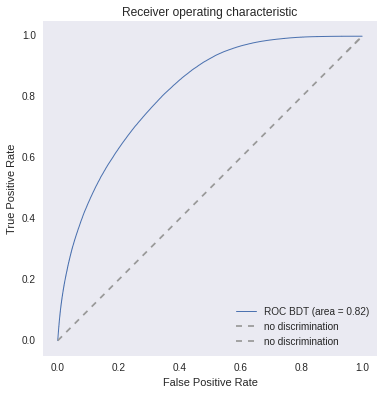

In [9]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb6.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

The result is the same no improvement! 
----------

The last idea is to perform grid search to find optimal values of **tree depth**, **gamma** and **min_child_weight**

In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = { "min_child_weight": [1,10,20,50],
                  "max_depth": [5,6,8,10]
                 }
print(gb_grid_params)

gb_gs = xgb.XGBClassifier(n_estimators=400, learning_rate=0.07 ,scale_pos_weight=ratio_ghost_to_good)

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=10);
clf.fit(train_gs_X, train_gs_Y);

{'max_depth': [5, 6, 8, 10], 'min_child_weight': [1, 10, 20, 50]}
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=10 ................................
[CV] max_depth=5, min_child_weight=10 ................................
[CV] max_depth=5, min_child_weight=10 ................................
[CV] max_depth=5, min_child_weight=20 ................................
[CV] max_depth=5, min_child_weight=20 ................................
[CV] max_depth=5, min_child_weight=20 ................................
[CV] max_depth=5, min_child_weight=50 ................................


In [ ]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

To be done! 
=========

Add linear combination and ratios of the features
-----------

As a very first step I add such features as 
* number of cluster minus number of layers
* number of hit in OT
* pseudo rapidity, momentum and transverse momentum divided by chi2 

And then I will try to find importance of it. 

In [17]:
def add_more_features(data):
    out = data
    out["seed_lhcbId-layers"] = data.seed_nLHCbIDs - data.seed_nLayers
    out["seed_ot"] = data.seed_nLHCbIDs - data.seed_nbIT
    out["seed_pr/chi2"] = data.pseudo_rapidity / data.seed_chi2PerDoF
    out["seed_p/chi2"] = data.seed_p/ data.seed_chi2PerDoF
    out["seed_tr"]= numpy.sqrt(numpy.square(data.seed_tx) +numpy.square(data.seed_ty))    
    return out

In [19]:
mf_data = add_more_features(new_data)
mf_features = mf_data.drop("is_true_seed", axis=1).astype(numpy.float64)
mf_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,...,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity,seed_lhcbId-layers,seed_ot,seed_pr/chi2,seed_p/chi2,seed_tr
0,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572,...,517.249191,0.524220,0.061572,1364.959300,0.505958,13,25,0.416870,2095.620933,0.527823
1,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081,...,99.363473,0.480288,0.009081,1268.420312,0.463589,13,25,0.344391,2066.311262,0.480374
2,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975,...,196.064807,0.382802,0.025975,1533.677219,0.374842,13,25,0.230299,2930.298550,0.383682
3,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753,...,483.850246,0.369674,0.058753,1636.317578,0.366082,13,25,0.204603,2907.907705,0.374314
4,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980,...,411.084316,0.646627,0.054980,1692.412576,0.610352,12,24,0.480881,1812.867601,0.648960


In [20]:
mf_trainX, mf_testX, mf_trainY, mf_testY = train_test_split(mf_features, target, random_state=42,train_size=0.5 )

In [22]:
gb5 = xgb.XGBClassifier( n_estimators=400, learning_rate=0.2, max_depth=6)
gb5.fit(mf_trainX, mf_trainY)
joblib.dump(gb5, 'models/XGBoost_400trees_linearFeatures.pkl') 

['models/XGBoost_400trees_linearFeatures.pkl',
 'models/XGBoost_400trees_linearFeatures.pkl_01.npy',
 'models/XGBoost_400trees_linearFeatures.pkl_02.npy']

In [23]:
print "ROC AUC score of XGBoost with 400 trees with additional linear combination of the features"
roc_auc_score(mf_testY, gb5.predict_proba(mf_testX)[:, 1])

ROC AUC score of XGBoost with 400 trees with additional linear combination of the features


0.81894167992847922

In [ ]:
tree_scores = [] 
for tree_nb in range(1,399):
    proba = gb5.predict_proba(mf_testX,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(mf_testY, predicted)
    print("".join(["tree ",str(tree_nb), " score ", str(score)]))
    tree_scores.append(score)

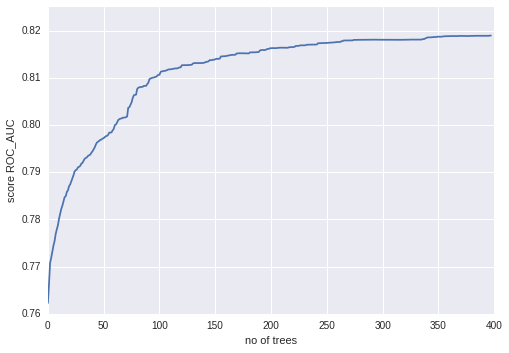

In [25]:
plt.figure()
plt.plot(tree_scores)
plt.ylim(0.76, 0.825)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Conclusion on selected linear combinations and ratios of the featured
-----------
Adding this features has no influence on classifier performance. 

# Try to speedup this algorithm.

LookupClassifier splits each of features into bins, trains a base_estimator to use this data.
To predict class for new observation, results of base_estimator are kept for all possible combinations of bins, and saved together. 

See also: this idea is used inside LHCb triggers, see V. Gligorov, M. Williams, 'Bonsai BDT'

As a very first step I will use **4 bin** per feature. It corresponds to array size of **4^12** .

Then I will try to tune using more complex binning strategy. I also need to reduce features space. I decided to remove "seed_x,y,tx,ty" and keep it's absolute values.  

In [9]:
new_features = new_features.drop(["seed_x","seed_y","seed_ty","seed_tx","seed_p"], axis=1).astype(numpy.float64)

In [10]:
new_features.head()

,seed_chi2PerDoF,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.213708,1187.267858,25,0,12,1263.157617,517.249191,0.524220,0.061572,1364.959300,0.505958
1,1.346112,1204.396954,25,0,12,1264.522435,99.363473,0.480288,0.009081,1268.420312,0.463589
2,1.627632,1708.511389,25,0,12,1521.093160,196.064807,0.382802,0.025975,1533.677219,0.374842
3,1.789231,1823.936187,25,0,12,1563.145597,483.850246,0.369674,0.058753,1636.317578,0.366082
4,1.269238,1252.585447,24,0,12,1641.727752,411.084316,0.646627,0.054980,1692.412576,0.610352


In [11]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )              

n_bins = 4

base_classifier = xgb.XGBClassifier(n_estimators=400, learning_rate=0.07 ,scale_pos_weight=ratio_ghost_to_good, max_depth=6)
classifier = LookupClassifier(base_estimator=base_classifier, n_bins=n_bins, keep_trained_estimator=False)
classifier.fit(train_X, train_Y)

LookupClassifier(base_estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.07, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=14.77, seed=0, silent=True, subsample=1),
         keep_trained_estimator=False, max_cells=500000000, n_bins=4)

In [12]:
print "ROC AUC score of binarized XGBoost with 400 trees and trained using scale positive weight"
roc_auc_score(test_Y, classifier.predict_proba(test_X)[:, 1])

ROC AUC score of binarized XGBoost with 400 trees and trained using scale positive weight


0.77325737147769302

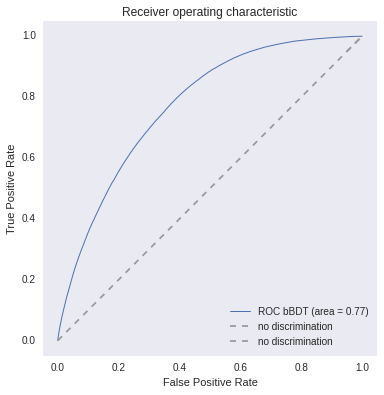

In [13]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, classifier.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC bBDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

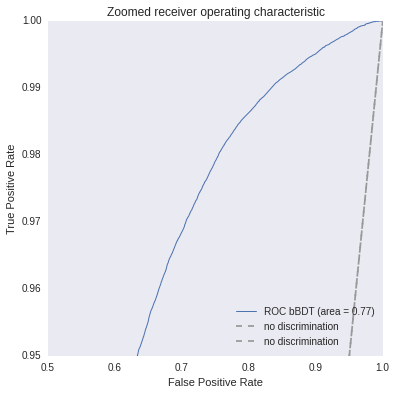

In [14]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, classifier.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC bBDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([0.5, 1])
plt.ylim([0.95, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Print the lookup table.
-------------
I want to see the structure of this array. 
I hope to find some structure. 

In [23]:
lookup_table = list(classifier._lookup_table[:,0])

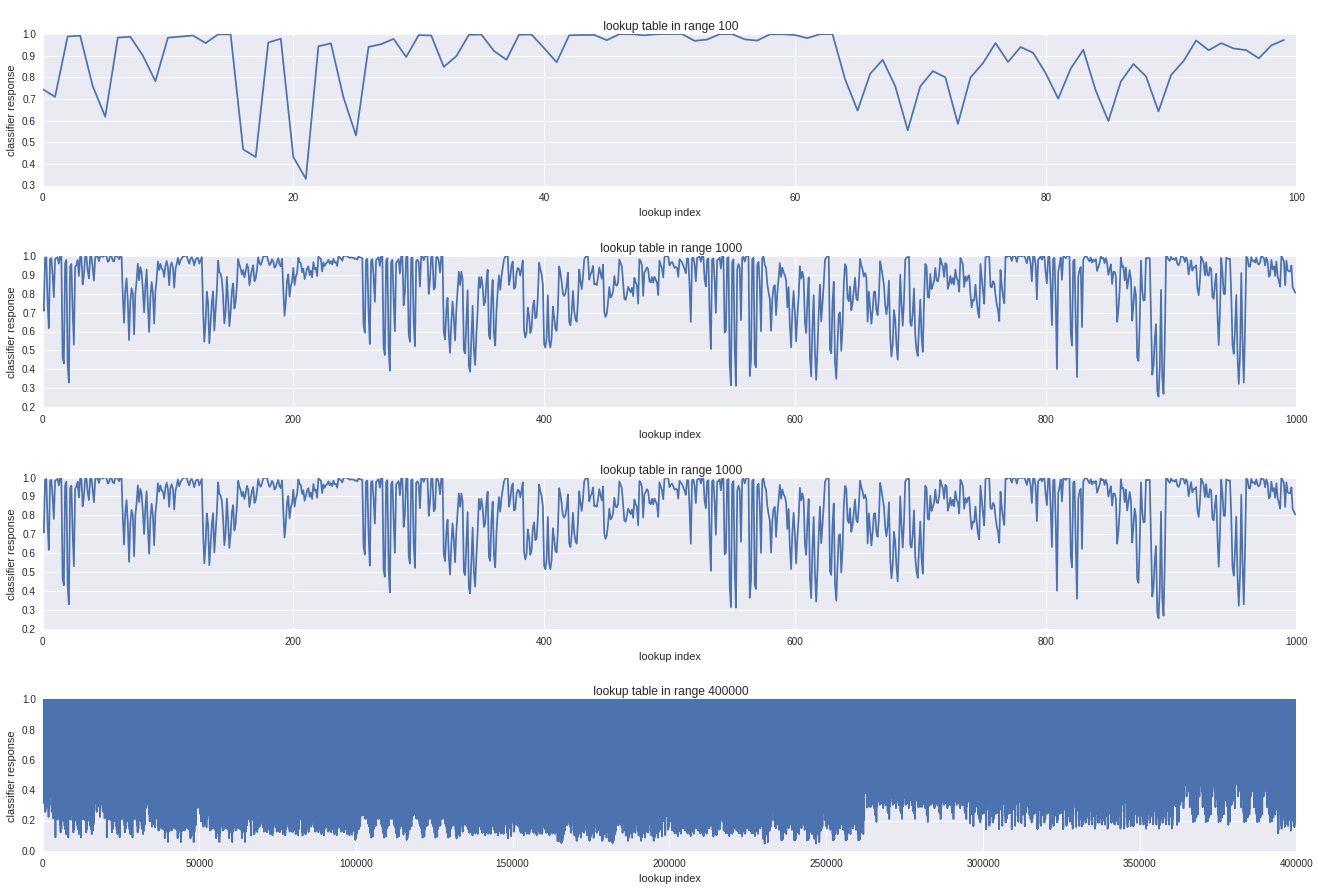

In [80]:
f, ax =  plt.subplots(4)
f.set_size_inches(18.5, 12.5)
ranges = [100,1000,1000,400000]
plot_it = 0
for plot_range in ranges:
    x = numpy.arange(0, plot_range)
    ax[plot_it].plot(x,lookup_table[:plot_range])
    ax[plot_it].set_title('\n lookup table in range %d'%plot_range)
    ax[plot_it].set_xlabel("lookup index")
    ax[plot_it].set_ylabel("classifier response")

    plot_it+=1
f.tight_layout() 


The structure of the lookup table is to complex to model it via some function. Bad news. 

Write model's parameters into c++ class.
------- 
I will generate source code of the class responsible for evaluation of the bBDT classifier.  
The template has been written manualy using CLion IDE. 
There will be 3 python function:
1. Generate header file (PatBBDTSeedClassifier.h),
2. Generate cpp file with all function except initialization of the lookup table (PatBBDTSeedClassifier.cpp)
3. Generate cpp file containing lookuptabel implementation (PatBBDTSeedClassifier_lookupTable.cpp) 
<font color="red">Warning! File size is about 550 MB</font>

I need to find a more smart way to transfer lookup table to c++. 

In [81]:
def generate_header():
    return """
/** This file was generated automaticly by python script 
https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/BDT-XGBoost.ipynb
DO NOT MODIFY IT MANUALLY!!!!!!
*/
    
#pragma once

#include "IPatMvaClassifier.h"
#include "PatKernel/IPatMvaClassifier.h"
#include "GaudiAlg/GaudiTool.h"
#include <vector>
#include <map>


class PatBBDTSeedClassifier : public GaudiTool, virtual public IPatMvaClassifier
{
public:
    PatBBDTSeedClassifier( const std::string& type,
                           const std::string& name,
                           const IInterface* parent);

    double getMvaValue(const std::vector<double>& parametersVector );

    virtual StatusCode initialize();

private:
    //initialization phase
    std::vector <std::pair<std::string, std::vector<double>>> initBinEdgeMaps();
    std::vector<double> initLookupTable();

    // model prediction phase
    std::vector<int> getBinIndices(const std::vector<double>& parametersVector);
    int convertBinIndicesToLookupIndex(std::vector<int>& binIndices);
    double getBBDTPrediction(int lookupIndex);


    std::vector <std::pair<std::string, std::vector<double>>> m_binsEdgeMap;
    std::vector<double> m_lookupTable;
};

"""

In [101]:
def generate_source_file():
    return """
#include "PatBBDTSeedClassifier.h"
#include <stdlib.h>
#include <stdio.h>

DECLARE_TOOL_FACTORY( PatBBDTSeedClassifier )

double PatBBDTSeedClassifier::getMvaValue(const std::vector<double>& parametersVector )
{
    auto binIndices = getBinIndices(parametersVector);
    int lookupTableIndex = convertBinIndicesToLookupIndex(binIndices);
    return getBBDTPrediction(lookupTableIndex);
}



PatBBDTSeedClassifier::PatBBDTSeedClassifier( const std::string& type,
                                                const std::string& name,
                                                const IInterface* parent )
        : GaudiTool ( type, name , parent )
{
    declareInterface<IPatMvaClassifier>(this);
}


StatusCode PatBBDTSeedClassifier::initialize()
{
    StatusCode sc =  GaudiTool::initialize();
    if(sc.isFailure()) return Error("Failed to initialize", sc);

    m_binsEdgeMap = initBinEdgeMaps();
    m_lookupTable = initLookupTable();
    return StatusCode::SUCCESS;
}

std::vector<int> PatBBDTSeedClassifier::getBinIndices(const std::vector<double>& parametersVector)
{
    std::vector<int> binIndicesMap;
    int actualFeature = 0;
    for (const auto& featurePair: m_binsEdgeMap){
        int binNumber = 0;
        for(const auto& binValue : featurePair.second) {
            if (parametersVector[actualFeature] > binValue) {
                binIndicesMap.push_back(binNumber);
                break;
            }
            binNumber++;
        }
        actualFeature++;
    }
    return binIndicesMap;
}
/**
 * adopt to C++ python method
 *  hep_ml.speedup.LookupClassifier.convert_lookup_index_to_bins()
 */


int PatBBDTSeedClassifier::convertBinIndicesToLookupIndex(std::vector<int> &binIndices)
{
    int index = 0;
    const int binPerFeature = 5;

    for (const auto& indice : binIndices){
        index *= binPerFeature+1;
        index += indice;
    }
    return index;
}

double PatBBDTSeedClassifier::getBBDTPrediction(int lookupIndex)
{
    return m_lookupTable[lookupIndex];
}
    """

In [102]:
def generate_InitBinEdgeMap_function():
    function_body = """
std::vector< std::pair<std::string, std::vector<double> > > PatBBDTSeedClassifier::initBinEdgeMaps()
{
    std::vector< std::pair<std::string, std::vector<double> > >   binMap ={
    """
    for feature, bins_edges in classifier.bin_edges.iteritems():
        function_body += "\t {\"" + str(feature) +"\", {"
        for bin_edge in bins_edges:
            function_body += str(bin_edge)+ ","
        function_body +=  "}},\n"
    
    function_body += """\n };
return binMap;
}
    """
    return function_body

In [103]:
def generate_initLookupTable_read_binary():
    function_body = """

/** right now I am using the simplest idea of importing lookup table.
 *  More sophisticated method is described in 
 *  http://stackoverflow.com/questions/39529799/initialization-of-very-big-vector-in-c/39531749#39531749
 *   thread. Don't know if will be implemented. 
 */

std::vector<double> PatBBDTSeedClassifier::initLookupTable()
{
    FILE *inFile;
    const int elementNumber = """
    function_body +=  str(len(classifier._lookup_table[:,0])) +";\n"
    function_body += """
    std::vector<double> lookup_table(elementNumber);
    if (!(inFile = fopen("BBDT_lookuptable_binary.dat", "rb")))
        exit(EXIT_FAILURE);

    fread(&lookup_table[0], sizeof(double), elementNumber, inFile);
    fclose(inFile);

    return lookup_table;
}
    """
    return function_body

In [106]:
file = open("models/cpp/PatBBDTSeedClassifier.h", 'w')
file.write(generate_header())
file.close()

file = open("models/cpp/PatBBDTSeedClassifier.cpp", 'w')
file_content = generate_source_file()
file_content += generate_InitBinEdgeMap_function()
file_content += generate_initLookupTable_read_binary()

file.write(file_content)
file.close()

This time I need to convert lookup table into vector.
-------
I will use three approaches:
1. Generate C++ function
2. Serialize the lookup table to binary file
3. Serialize the lookup table to text file

In [94]:
def generate_initLookupTable_cpp_source_function():
    numbers_per_row = 100
    function_body = """
#include "PatBBDTSeedClassifier.h"

std::vector<double> PatBBDTSeedClassifier::initLookupTable()
{
   std::vector<double> indicesVector ={
    """
    row_nb = 1
    for bin_value in classifier._lookup_table[:,0]:
        function_body += "\t" + str(bin_value) +" , "
        if (row_nb % numbers_per_row) == 0:
            function_body += "\n"
        row_nb += 1
    
    function_body += """\n };
return indicesVector;
}
    """
    return function_body

Write lookup table to c++ source file. 
----------
The size of this file is huge ~ 500 MB! 


In [86]:
file = open("models/cpp/PatBBDTSeedClassifier_lookupTable.cpp", 'w')
file.write(generate_initLookupTable_function())
file.close()

Save lookup table to binary file
------------

In [107]:
from struct import pack
file_name ="models/cpp/BBDT_lookuptable_binary.dat"
with open(file_name, 'wb') as file_out:
    for u in classifier._lookup_table[:,0]:
        file_out.write(pack(b'<d', u)) # Pack doubles as little-endian 

Write lookup table to text file 
--------------
This approach allows me to easy grab this parameters. 

In [90]:
file = open("models/cpp/BBDT_lookuptable.dat", 'w')
table = numpy.array(classifier._lookup_table[:,0])
table.tofile(file)
file.close()

Now you can go to the next model - [Logistic Regression](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/LogisticRegression.ipynb)    
=========